In [1]:
######## Packages ########
import numpy as np 
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML 
from math import e

## 4.3.2
ポアソン混合モデルの事後分布からパラメータと潜在変数をサンプルする．
- 参考
    - https://www.anarchive-beta.com/entry/2020/04/17/225141

ここでは，2つのポアソン分布を混合することによって得られた2峰性の1次元データに対してギブスサンプリングを適用する．

In [2]:
#################### param (truth) ####################
lambda_truth = np.array([20, 55])
pi_truth = np.array([0.4, 0.6])
#######################################################

In [3]:
#################### Param (observed) ####################
N = 100                 # the number of observed data
K = len(lambda_truth)   # the number of clusters
##########################################################


#################### Clusters (Eq.(4.2)) ####################
s_nk = stats.multinomial(n=1, p=pi_truth).rvs(size=N)
#############################################################


#################### Observed data (Eq.(4.28)) ####################
def generate_observed_data(lmd, s, K):
    dt = 1
    for k in range(K):
        val = stats.poisson(mu = lmd[k]).rvs()
        dt = dt*val**s[k]
    return dt

x_n = []
for n in range(N):
    x_n.append(generate_observed_data(lmd=lambda_truth, s=s_nk[n], K=K))
x_n = np.array(x_n)
###################################################################

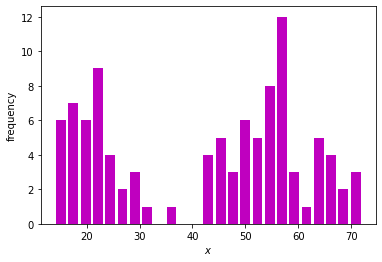

In [4]:
#################### Plot observed data ####################
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel(r"$x$"); ax.set_ylabel("frequency")
ax.hist(x_n, bins=25, rwidth=0.8, color='m')
plt.show()
############################################################

In [5]:
#################### Param (estimation) ####################
maxiter = 50                # the number of iteration
a = 1; b = 1                # hyper parameter for gamma distribution
alpha = np.array([2, 2])  # hyper parameter for Dirichlet distribution
############################################################

#################### Generate initial value ####################
lambda_init = stats.gamma(a=a, scale=1/b).rvs(size=K)
pi_init = stats.dirichlet(alpha=alpha).rvs()[0]
################################################################


In [6]:
#################### list ####################
def make_list(n):
    return [[] for i in range(n)]
##############################################

In [7]:
#################### Gibbs sampling ####################
def gibbs_poisson(maxiter, N, K, lambda_init, pi_init, x, a, b, alpha):
    #################### Initialization ####################
    S_list = []; Lambda_list = []; Pi_list = []
    hat_a_list = make_list(K); hat_b_list = make_list(K); hat_alpha_list = []
    for k in range(K):
        hat_a_list[k].append(a); hat_b_list[k].append(b)
    hat_alpha_list.append(alpha)
    ########################################################

    #################### Loop process ####################
    for i in range(maxiter):
        if i == 0:
            l_current = lambda_init.tolist(); p_current = pi_init.tolist()
        else:
            l_current = Lambda_list[-1].tolist(); p_current = Pi_list[-1].tolist()
        #################### s_n ####################
        S_current = []
        for n in range(N):
            ###### Calculate eta_n (Eq.(4.38)) ######
            eta_tmp = []
            for k in range(K):
                eta_tmp.append(e**(x[n]*np.log(l_current[k]) - l_current[k] + np.log(p_current[k])))
            eta_n = np.array(eta_tmp) / sum(eta_tmp)  # normalization
            #########################################
            ###### Sample s_n (Eq.(4.37)) ######
            s_n = stats.multinomial(n=1, p=eta_n).rvs()[0]
            S_current.append(s_n)
            ####################################
        S_current = np.array(S_current); S_list.append(S_current)
        #############################################

        #################### lambda ####################
        l_new = []
        for k in range(K):
            ###### Calculate hat_a and hat_b (Eq.(4.42)) ######
            hat_a = np.sum(S_current.T[k] * x) + a; hat_a_list[k].append(hat_a)
            hat_b = np.sum(S_current.T[k]) + b; hat_b_list[k].append(hat_b)
            ###################################################
            ###### Sample lambda (Eq.(4.41)) ######
            l_k = stats.gamma(a=hat_a, scale=1/hat_b).rvs()
            l_new.append(l_k)
            #######################################
        Lambda_list.append(np.array(l_new))
        ###############################################
        
        #################### pi ####################
        ###### Calculate hat_alpha (Eq.(4.45)) ######
        hat_alpha = []
        for k in range(K):
            hat_alpha_k = np.sum(S_current.T[k]) + alpha[k]
            hat_alpha.append(hat_alpha_k)
        hat_alpha = np.array(hat_alpha); hat_alpha_list.append(hat_alpha)
        #############################################
        ###### Sample pi (Eq.(4.44)) ######
        pi_new = stats.dirichlet(alpha=hat_alpha).rvs()[0]
        ###################################
        Pi_list.append(pi_new)
        ############################################
    #########################################################
    S_list = np.array(S_list); Lambda_list = np.array(Lambda_list); Pi_list = np.array(Pi_list)
    return S_list, Lambda_list, Pi_list, hat_a_list, hat_b_list, hat_alpha_list
###############################################################

In [8]:
#################### execute Gibbs sampling ####################
S_sample, Lambda_sample, Pi_sample, hat_a_sample, hat_b_sample, hat_alpha_sample = gibbs_poisson(maxiter=maxiter, N=N, K=K, lambda_init=lambda_init, pi_init=pi_init, x=x_n, a=a, b=b, alpha=alpha)
################################################################

MovieWriter imagemagick unavailable; using Pillow instead.


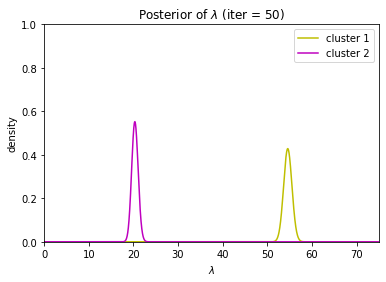

In [9]:
# post
z1 = np.linspace(0, 75, 7501)   # lambda
## lambda
lambda_pdf_post = make_list(K)
for i in range(maxiter + 1):
    for k in range(K):
        cluster_k = stats.gamma(a=hat_a_sample[k][i], scale=1/hat_b_sample[k][i]).pdf(z1)
        lambda_pdf_post[k].append(cluster_k)

### plot lambda
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

def update_lambda(frame):
    ax.clear()
    ax.set_xlabel(r"$\lambda$"); ax.set_ylabel("density")
    ax.set_title("Posterior of " + r"$\lambda$ " + "(iter = {})".format(frame))
    ax.set_xlim([0, 75]); ax.set_ylim([0, 1])
    #### plot pdf ####
    color_list = ["y", "m"]
    for k in range(K):
        ax.plot(z1, lambda_pdf_post[k][frame], color=color_list[k], label="cluster {}".format(k + 1))
    ax.legend(loc="upper right")

ani = animation.FuncAnimation(fig, update_lambda, frames=maxiter+1, interval=200)
ani.save("4.3.2_posteior_lambda.gif", writer="imagemagick")
HTML(ani.to_jshtml())

MovieWriter imagemagick unavailable; using Pillow instead.


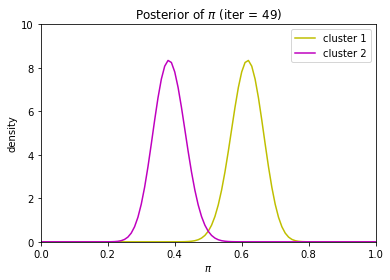

In [10]:
## pi (Dir -> beta)
z2 = np.linspace(0, 1, 101)
pi_post = make_list(K); K_list = list(range(K))
for i in range(1, maxiter + 1):
    for k in K_list:
        key = list(set(K_list) - {k})[0]
        pi = stats.beta(a=hat_alpha_sample[i][k], b=hat_alpha_sample[i][key]).pdf(z2)
        pi_post[k].append(pi)

### post pi
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

def update_pi(frame):
    ax.clear()
    ax.set_xlabel(r"$\pi$"); ax.set_ylabel("density")
    ax.set_title("Posterior of " + r"$\pi$ " + "(iter = {})".format(frame))
    ax.set_xlim([0, 1]); ax.set_ylim([0, 10])
    ### plot pdf
    color_list = ["y", "m"]
    for k in range(K):
        ax.plot(z2, pi_post[k][frame], color=color_list[k], label="cluster {}".format(k + 1))
    ax.legend(loc="upper right")

ani = animation.FuncAnimation(fig, update_pi, frames=range(1, maxiter), interval=200)
ani.save("4.3.2_posteior_pi.gif", writer="imagemagick")
HTML(ani.to_jshtml())

